# Preprocessing - Modeling

In [3]:
import os
import sys
import pandas as pd
import numpy as np

import time

from wordcloud import WordCloud
from pandas_profiling import ProfileReport

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as plty

import plotly.express as px

import missingno as msno

# Textacy

import spacy
from spacy.matcher import Matcher
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

#https://realpython.com/natural-language-processing-spacy-python/
matcher = Matcher(nlp.vocab)

join_comments = True
join_raw_article = True

# Set Project Root
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)


# %run "$BASE_DIR/settings.py"
%config InlineBackend.figure_format = 'png'

# Set to Reload all custom packages
%load_ext autoreload
%autoreload 2

%matplotlib inline

# !python -m spacy download en_core_web_sm

from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import log_loss

import time

import lightgbm as lgb

g:\My Drive\Code\springboard_proj_nlp_nytimes


## Load Data

In [4]:
## Load exit from EDA
df_articles = pd.read_pickle('..//data//processed//df_articles_fe.pkl')
df_articles.reset_index(drop=True,inplace=True)
df_articles.drop(columns=['print_section','print_page'],inplace=True)


In [5]:
df_articles.iloc[20].T

newsdesk                                                             Politics
section                                                                  U.S.
material                                                                 News
abstract                    Interrupting Joe Biden nearly every time he sp...
keywords                    ['Biden, Joseph R Jr', 'Trump, Donald J', 'Deb...
word_count                                                               1941
pub_date                                            2020-09-30 03:28:29+00:00
n_comments                                                               4044
uniqueID                    nyt://article/28229317-87b2-5b05-b036-71235665...
lead_paragraph              [Read our profile detailing Joe Biden’s road t...
month                                                                       9
TEXT_Keywords_POS_NOUN                                                      2
TEXT_Keywords_POS_PNOUN                                         

In [6]:
df_articles.describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,16786.0,1300.961813,944.801861,0.0,874.0,1183.0,1502.0,15619.0
n_comments,16786.0,297.056714,513.419176,1.0,21.0,87.0,323.0,8987.0
month,16786.0,6.320743,3.437056,1.0,3.0,6.0,9.0,12.0
TEXT_Keywords_POS_NOUN,16786.0,3.038067,2.411232,0.0,1.0,3.0,4.0,23.0
TEXT_Keywords_POS_PNOUN,16786.0,13.809008,9.945966,0.0,7.0,12.0,19.0,146.0
TEXT_Keywords_ENT_ORG,16786.0,1.514417,1.617064,0.0,0.0,1.0,2.0,18.0
TEXT_Keywords_ENT_NORP,16786.0,0.076552,0.285341,0.0,0.0,0.0,0.0,3.0
TEXT_Keywords_ENT_FAC,16786.0,0.015668,0.141670,0.0,0.0,0.0,0.0,4.0
TEXT_Keywords_ENT_GPE,16786.0,0.845466,1.218005,0.0,0.0,0.0,1.0,37.0
TEXT_Keywords_ENT_LOC,16786.0,0.038723,0.222482,0.0,0.0,0.0,0.0,5.0


### Split number of comments into high and low comments, count differences

In [7]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16786 entries, 0 to 16785
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   newsdesk                  16786 non-null  object             
 1   section                   16786 non-null  object             
 2   material                  16786 non-null  object             
 3   abstract                  16783 non-null  object             
 4   keywords                  16786 non-null  object             
 5   word_count                16786 non-null  int64              
 6   pub_date                  16786 non-null  datetime64[ns, UTC]
 7   n_comments                16786 non-null  int64              
 8   uniqueID                  16786 non-null  object             
 9   lead_paragraph            16786 non-null  object             
 10  month                     16786 non-null  int64              
 11  TEXT_Keywords_P

# Classifier
## Target - n_comments - High or Low?

## Preprocessing

In [8]:
# convert labels to features
number = LabelEncoder()
df_articles['newsdesk_num'] = number.fit_transform(df_articles['newsdesk'])
number = LabelEncoder()
df_articles['section_num'] = number.fit_transform(df_articles['section'])
number = LabelEncoder()
df_articles['material_num'] = number.fit_transform(df_articles['material'])


## EDA Final
Look over reports before running model

In [13]:
profile_articles_final = ProfileReport(df_articles, title="New York Times - Articles - Final")
profile_articles_final.to_file('..//reports//figures//EDA_Articles_Final.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


# Train Test Split

In [9]:
X = df_articles[['TEXT_Keywords_POS_NOUN',
                    'TEXT_Keywords_POS_PNOUN',
                    'TEXT_Keywords_ENT_ORG',
                    'TEXT_Keywords_ENT_NORP',
                    'TEXT_Keywords_ENT_FAC',
                    'TEXT_Keywords_ENT_GPE',
                    'TEXT_Keywords_ENT_LOC',
                    'TEXT_Keywords_ENT_PERSON',
                    'word_count','section_num',
                    'newsdesk_num',
                    'material_num',
                    'month'
                                    ]]

y = df_articles['comment_isHigh']



In [10]:
X.shape

(16786, 13)

In [11]:
y.shape

(16786,)

In [12]:
y.value_counts()

0    12838
1     3948
Name: comment_isHigh, dtype: int64

## LightGBM Classifer

# Stratified K Fold Validatation

In [13]:
# https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997
N_SPLITS = 10
strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
    print(f"Training fold {idx}")

    start = time.time() # Capture Start time

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    eval_set = [(X_test, y_test)]

    lgb_clf = lgb.LGBMClassifier(n_estimators=1000)
    lgb_clf.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        # categorical_feature=cat_idx,
        early_stopping_rounds=100,
        eval_metric="binary_logloss",
        verbose=False,
    )

    preds = lgb_clf.predict_proba(X_test)
    loss = log_loss(y_test, preds)
    scores[idx] = loss
    runtime = time.time() - start
    print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")

Training fold 0


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 finished with score: 0.34752 in 0.37 seconds.

Training fold 1


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 finished with score: 0.35463 in 0.37 seconds.

Training fold 2


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 finished with score: 0.34784 in 0.58 seconds.

Training fold 3


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 finished with score: 0.34368 in 0.43 seconds.

Training fold 4


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 finished with score: 0.36947 in 0.22 seconds.

Training fold 5


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 5 finished with score: 0.35769 in 0.35 seconds.

Training fold 6


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 6 finished with score: 0.33779 in 0.47 seconds.

Training fold 7
Fold 7 finished with score: 0.37361 in 0.20 seconds.



C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training fold 8


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 8 finished with score: 0.36209 in 0.31 seconds.

Training fold 9


C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 9 finished with score: 0.36594 in 0.23 seconds.



In [14]:
print(f"Average log loss: {np.mean(scores):.4f}")
print(f"Standard Deviation log loss: {np.std(scores):.4f}")

Average log loss: 0.3560
Standard Deviation log loss: 0.0112


## Predict Binary Classification of size of comments

In [15]:
# Train Test Split 80/10
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,test_size=0.2, random_state=42)

In [16]:
y_train.shape

(13428,)

In [17]:
y_test.shape

(3358,)

In [18]:
MODEL_PARAMS = {'random_state': 42,    
                'learning_rate': 0.05,                
                'n_estimators': 900,
                'objective': 'binary'}  # Type

model = lgb.LGBMClassifier(**MODEL_PARAMS)

In [19]:
model.fit(X_train,
            y_train,
            eval_metric='binary_logloss',
            eval_set=[(X_test,y_test),(X_train,y_train)],
            early_stopping_rounds=100,
            verbose=False)

C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Mike\.conda\envs\NLP\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.05, n_estimators=900, objective='binary',
               random_state=42)

In [20]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.8648
Testing accuracy 0.8440


In [21]:
preds = model.predict(X_test)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

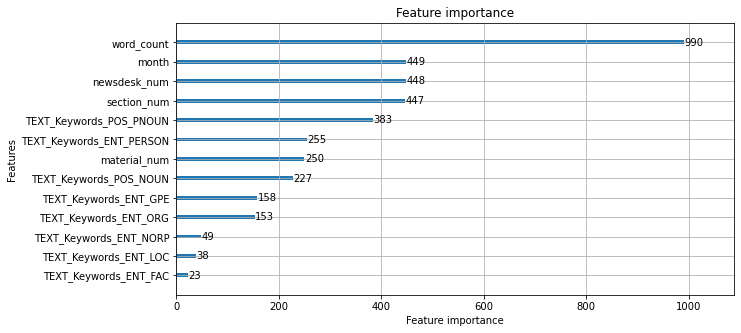

In [22]:
plt.rcParams['figure.figsize']=10,5
lgb.plot_importance(model)

In [23]:
X_test.shape,y_test.shape

((3358, 13), (3358,))

In [24]:
y_test.value_counts()

0    2591
1     767
Name: comment_isHigh, dtype: int64

C:\Users\Mike\.conda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


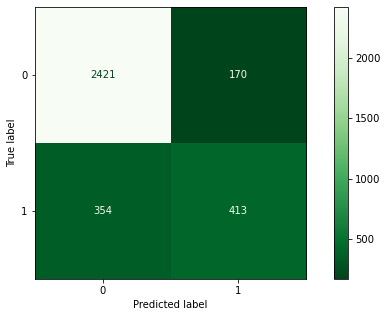

In [25]:
metrics.plot_confusion_matrix(model,X_test,y_test,cmap='Greens_r')
# https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/

In [26]:
# Predict Probababilities for X_test data with 0, 1 class order
probas = model.predict_proba(X_test)
probas

array([[0.96830138, 0.03169862],
       [0.90382093, 0.09617907],
       [0.83997774, 0.16002226],
       ...,
       [0.94017818, 0.05982182],
       [0.97280369, 0.02719631],
       [0.97182414, 0.02817586]])

In [27]:
probas_L = pd.Series(data=probas[:,0],name='proba_L',index=X_test.index)
probas_H = pd.Series(data=probas[:,1],name='proba_H',index=X_test.index)

X_test['probas_L'] = probas_L
X_test['probas_H'] = probas_H

X_test['comment_size_predict'] = preds
X_test['comment_size_actual'] = y_test

df_results = X_test

In [28]:
df_results[['comment_size_predict','comment_size_actual']].value_counts()

comment_size_predict  comment_size_actual
0                     0                      2421
1                     1                       413
0                     1                       354
1                     0                       170
dtype: int64

In [29]:
print(classification_report(y_test,preds))


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2591
           1       0.71      0.54      0.61       767

    accuracy                           0.84      3358
   macro avg       0.79      0.74      0.76      3358
weighted avg       0.83      0.84      0.84      3358



# Calculate Lift

In [30]:
df_results.head(1).T

,10155
TEXT_Keywords_POS_NOUN,5.000000
TEXT_Keywords_POS_PNOUN,17.000000
TEXT_Keywords_ENT_ORG,2.000000
TEXT_Keywords_ENT_NORP,0.000000
TEXT_Keywords_ENT_FAC,0.000000
TEXT_Keywords_ENT_GPE,0.000000
TEXT_Keywords_ENT_LOC,0.000000
TEXT_Keywords_ENT_PERSON,3.000000
word_count,1181.000000
section_num,25.000000


In [32]:
df_lift = df_results.sort_values(by='probas_H',ascending=False)

In [34]:
df_lift[['probas_L','probas_H','comment_size_predict','comment_size_actual']]

,probas_L,probas_H,comment_size_predict,comment_size_actual
944,0.042639,0.957361,1,1
1053,0.042848,0.957152,1,1
353,0.043396,0.956604,1,1
217,0.044086,0.955914,1,1
411,0.045024,0.954976,1,1
...,...,...,...,...
13430,0.995618,0.004382,0,0
12304,0.995866,0.004134,0,0
14715,0.995896,0.004104,0,0
15046,0.996451,0.003549,0,0


In [38]:
df_allresults = X_test.sort_values(by='probas_H',ascending=False)

### Calculate Model Lift

In [197]:
# https://towardsdatascience.com/model-lift-the-missing-link-70eb37460e67
def generate_lift(df,bins):

    # Rename columns for af_scoring column
    df_score = df[['comment_size_predict','probas_L','probas_H']].rename(columns={"comment_size_predict": "Target", 
                                                                                    "probas_L": "PR_0", 
                                                                                    "probas_H": "PR_1"}, errors="raise")
    #  Make numeric scoring groups 1 to bin size                                                    
    df_score['scoring_group'] = pd.qcut(df_score['PR_0'],bins,labels=False)+1

    df_lift = pd.crosstab(df_score['scoring_group'], df_score['Target']).reset_index()
    df_lift = df_lift.rename(columns= {'Target':'Np', 
                                        0: '0', 
                                        1: '1'})
    
    # Sum of ones and zeros
    zeros_sum = df_lift['0'].sum()
    ones_sum = df_lift['1'].sum()
    avg_resp_rate = ones_sum/(ones_sum+zeros_sum)

    # Proportion of '1's in a bin
    # Round to two decimals
    df_lift['response_rate'] = round(df_lift['1'] / (df_lift['1'] + df_lift['0']),2)
    # Calculate Lift, which is factor better than choosing articles randomly
    df_lift['lift'] = round((df_lift['response_rate'] / avg_resp_rate),2)
    df_lift['rand_resp'] = 1 / bins
    df_lift['cmltv_p'] = round((df_lift['1']).cumsum(),2)

    # Cumulative % of positives
    df_lift['cmltv_p_perc'] = round(((df_lift['1'] / ones_sum).cumsum())*100,1)
    df_lift['cmltv_n'] = round((df_lift['0']).cumsum(),2)  
    # Cumulative % of negatives
    df_lift['cmltv_n_perc'] = round(((df_lift['0'] / zeros_sum).cumsum())*100,1)   
    # cumulative Random % positive
    df_lift['cmltv_rand_p_perc'] = (df_lift.rand_resp.cumsum())*100
    # Cumulative Response Rate
    df_lift['cmltv_resp_rate'] = round(df_lift['cmltv_p'] / (df_lift['cmltv_p']+df_lift['cmltv_n']),2)   
    # Cumulative Lift
    df_lift['cmltv_lift'] = round(df_lift['cmltv_resp_rate'] / avg_resp_rate,2)
    # Kolmogorov-Smirnov Test
    df_lift['KS'] = round(df_lift['cmltv_p_perc'] - df_lift['cmltv_rand_p_perc'],2)
    df_lift = df_lift.drop(['rand_resp','cmltv_p','cmltv_n',], axis=1)
    
    print('average response rate: ' , avg_resp_rate)
    return df_lift

In [39]:
df_lift_results = generate_lift(df_lift,bins=10)
df_lift_results.iloc[0:2]

NameError: name 'generate_lift' is not defined

### Plot Model Lift

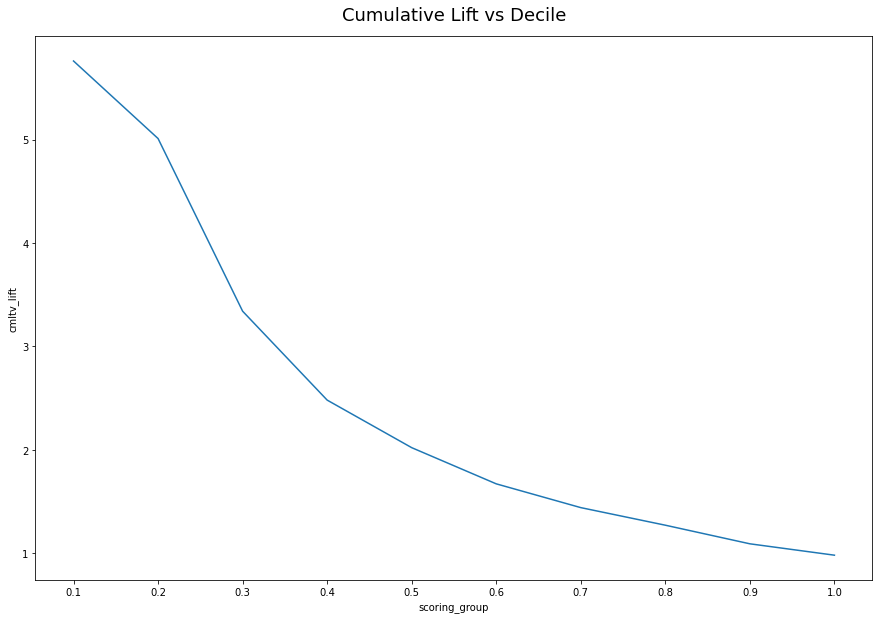

In [231]:
plt.figure(figsize=(15, 10))
plot = sns.lineplot(data=df_lift_results,y='cmltv_lift',x='scoring_group')
plot.set_title('Cumulative Lift vs Decile', fontdict={'fontsize':18}, pad=16)
plt.xticks(df_lift_results['scoring_group'],['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']);